<img src="https://www.analyticsvidhya.com/wp-content/themes/Curated/custom-design/images/logo.png" width=240 height= 240 align="right"/>

# Text Classification using nltk, spaCy, and Scikit-learn

“Text Classification” is one of the most important NLP tasks. It is the process of classifying text strings or documents into different categories, based upon the contents of the strings. Some examples of text classification are:

* Understanding audience sentiment from social media,
* Detection of spam and non-spam emails,
* Auto tagging of customer queries, and
* Classifying blog posts into different categories.

In this notebook, we will work on a text classification problem, end-to-end. For this analysis, we’ll be using the __IMDb movie reviews dataset__ compiled by [Andrew Maas](http://ai.stanford.edu/~amaas/)  and can be found [here](http://ai.stanford.edu/~amaas/data/sentiment/). However, we will be using a smaller version of the dataset which comes bundled with this Jupyter notebook.

*Note: Python version = 3.6*

### Table of Contents

1. Understand the Problem Statement
2. Read Dataset
3. Clean and Pre-Process Text
4. Split Data
4. Extracting Features from Cleaned Text
5. Model Building

<br>

### Understand the Problem Statement

A movie review is a widely used means for movie critics to assess a film’s overall quality and determine
whether or not they think the film is worth watching. In this project, our task is to classify these IMDb movie reviews into 'positive' and 'negative' reviews. 

### Read Dataset

Let's import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import nltk
import spacy
from tqdm import tqdm
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

There are two folders named "positive" and "negative" containing text files of positive and negative movie reviews, respectively. We will have to first read and load the contents of these text files (reviews) to move ahead with our analysis.

In [114]:
# load file names
pos_files = os.listdir("positve/")
neg_files = os.listdir("negative/")

In [3]:
print(pos_files[:10])

['9490_10.txt', '5367_9.txt', '7558_8.txt', '5068_9.txt', '3462_7.txt', '11859_10.txt', '8553_7.txt', '10022_7.txt', '4030_9.txt', '374_10.txt']


In [4]:
print(neg_files[:10])

['2620_3.txt', '11631_1.txt', '9636_1.txt', '1928_1.txt', '11279_1.txt', '8994_2.txt', '2528_2.txt', '8002_1.txt', '6515_1.txt', '6474_3.txt']


...................................................................................................................

Let's see how many negative and postive reviews are there.

In [5]:
len(pos_files), len(neg_files)

(10000, 8000)

So, there are 10,000 positive reviews and 8,000 negative reviews. Till now we have just gathered the names of files that we have to read. To read them, let's define a function.

In [6]:
# function to read text files
def read_review(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [7]:
# read and store positive reviews in a list
pos = []

for i in pos_files:
    pos.append(read_review("positve/"+i))
    
# read and store negative reviews in a list
neg = []

for i in neg_files:
    neg.append(read_review("negative/"+i))

We will now put both positive and negative reviews in a dataframe. We will also assign 1 to the positive reviews and 0 to the negative reviews.

In [ ]:
df = pd.DataFrame({'review':(pos+neg)})

# '1' for positive reviews and '0' for negative reviews
df['class'] = 0
df['class'][:10000] = 1

In [9]:
# check class distribution
df['class'].value_counts()

1    10000
0     8000
Name: class, dtype: int64

<br>

### Clean and Pre-Process Text

Cleaning and pre-processing of raw text data is an important step in an NLP task. We try to remove as much noise as possible from the data. Punctuation marks, special characters(#@&<!), and words like 'the', 'a', 'of', 'oh' are of not much use in tasks like text classification, and that is why they are considered as noise. So, before getting started, let's print out a random review.  

In [10]:
df['review'][4]

'This was the first televised episode of the Columbo series (although it was filmed after "Death Lends a Hand")and it heralded one of the most successful TV series in history.<br /><br />Jack Cassidy (who played the murderer in the series three times) enthuses smugness, arrogance and self-assuredness in equal measure here, as Ken Franklin, one half of a mystery writing team who hatches an elaborate plot to kill off his partner, Jim Ferris (played by Martin Milner) who decides to terminate their professional relationship, leaving Franklin exposed as merely a good publicist rather than a prolific writer.<br /><br />The initial murder set-up is fantastic and Cassidy\'s performance facilitates an arguable accolade that he was the best Columbo murderer in the series.<br /><br />Peter Falk is wonderfully understated in his role as Columbo and the character\'s inherent traits and oddities, which are underlined by a seeming slowness and absent-mindedness, contrast particularly well with Cassid

...................................................................................................................

As you can see, we have lots of punctuation marks and html tags. To get rid of them from the text we will take help of regular expressions. 

In [11]:
replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# function to clean text data
def clean_reviews(reviews):
    reviews = [replace_1.sub("", line.lower()) for line in reviews]
    reviews = [replace_2.sub(" ", line) for line in reviews]
    return reviews

In [12]:
df['review'] = clean_reviews(df['review'])

Let's pull out the same review after the cleaning operation.

In [13]:
df['review'][4]

'this was the first televised episode of the columbo series although it was filmed after death lends a handand it heralded one of the most successful tv series in history jack cassidy who played the murderer in the series three times enthuses smugness arrogance and self assuredness in equal measure here as ken franklin one half of a mystery writing team who hatches an elaborate plot to kill off his partner jim ferris played by martin milner who decides to terminate their professional relationship leaving franklin exposed as merely a good publicist rather than a prolific writer the initial murder set up is fantastic and cassidys performance facilitates an arguable accolade that he was the best columbo murderer in the series peter falk is wonderfully understated in his role as columbo and the characters inherent traits and oddities which are underlined by a seeming slowness and absent mindedness contrast particularly well with cassidys characters extreme smugness one of their early scene

...................................................................................................................

It seems pretty neat and free from unwanted elements. Now let's see which are the top most frequent words in the data.

In [14]:
from nltk import FreqDist

In [15]:
# function to plot top n most frequent words
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

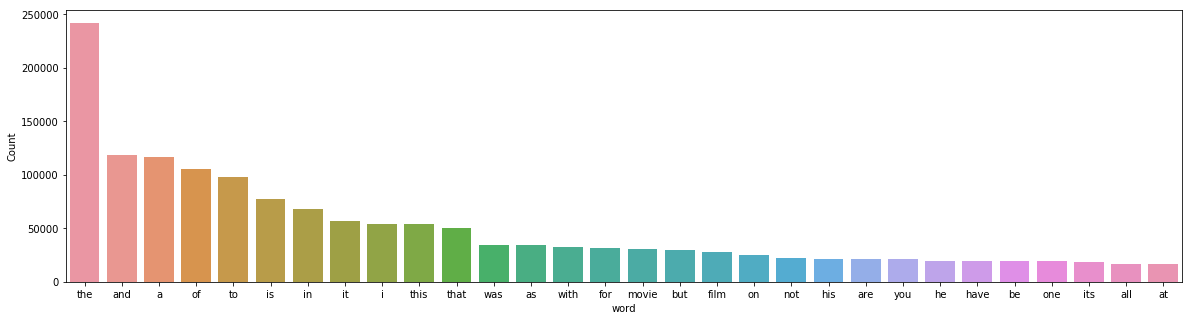

In [16]:
freq_words(df['review'])

As it turns out, terms like 'and', 'a', 'is', that' etc. are the most common terms in our data. Most of them are also known as stopwords in the NLP community, and they would be of little help in identifying a review as positive or negative. Hence, we will get rid of them as well. 

We will use __spaCy library__ here to remove the stopwords. But first you have to download spaCy's language model 'en_core_web_sm'. Use the comman below in your terminal to download and install the language model.

```python -m spacy download en_core_web_sm```

More info on spaCy's language models can be found here https://spacy.io/usage/models

In [3]:
nlp = spacy.load('en_core_web_sm')

However, there are a few stopwords which should not be removed as their absence might change the meaning of an entire sentence. So, we won't remove the words 'however', 'no', 'not', and 'but'. We will take them off from spaCy's stopwords vocabulary in the following code block.

In [19]:
nlp.vocab['however'].is_stop = False
nlp.vocab['no'].is_stop = False
nlp.vocab['not'].is_stop = False
nlp.vocab['but'].is_stop = False

__Tokenization__

To remove the stopwords, we will have to first tokenize our reviews. Tokenization means splitting a piece of text into its constituent words. For example, the sentence below will be split into a list of tokens/words after tokenization.

__"The cutting edge of the plot is compromised" --> ['The', 'cutting', 'edge', 'of', 'the', 'plot', 'is', 'compromised']__

We will again use spaCy for tokenizaion. First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

* Does the substring match a tokenizer exception rule? For example, "don't" does not contain whitespace, but should be split into two tokens, "do" and "n't", while "U.K." should always remain one token.
 
* Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there's a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

<img src="https://spacy.io/assets/img/tokenization.svg" align="center"/>


In [20]:
# tokenization using spaCy
def tokenization(x):
    reviews_tokens = []
    for i in tqdm(x):
        i = nlp(i)
        temp = []
        for j in i:
            temp.append(j.text)
        reviews_tokens.append(temp)
    
    return reviews_tokens

In [29]:
df['tokenized_review'] = tokenization(df['review'])

100%|██████████| 18000/18000 [17:19<00:00, 12.82it/s]


In [62]:
# function to remove stopwords
def strip_stopwords(reviews):
    s = []
    for r in tqdm(reviews):
        s_2 = []
        for token in r:
            if nlp.vocab[token].is_stop == True:
                continue
            else:
                s_2.append(token)
        s.append(" ".join(s_2))    
        
    return s

Let's remove the stopwords.

In [80]:
df['review_cleaned'] = strip_stopwords(df['tokenized_review'])

100%|██████████| 18000/18000 [00:04<00:00, 4337.67it/s]


We will again check the most common terms in the cleaned review text after eliminating the stopwords.

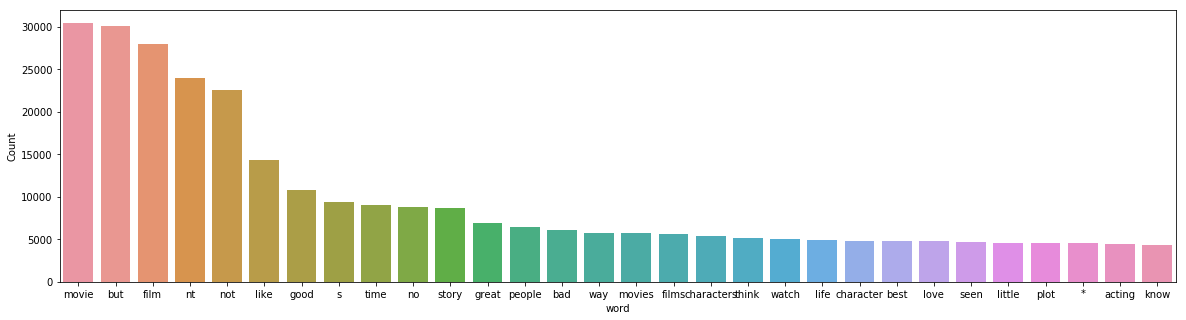

In [81]:
freq_words(df['review_cleaned'])

Now we can see more relevant terms have come up. Words such as 'movie', 'film', 'story', 'character' as most frequently appearing words make sense. However, we can further clean up the data. Let's get rid of single character terms. 

In [82]:
# remove 1 character terms (length == 1)
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

One more glance at the top 30 most common words.

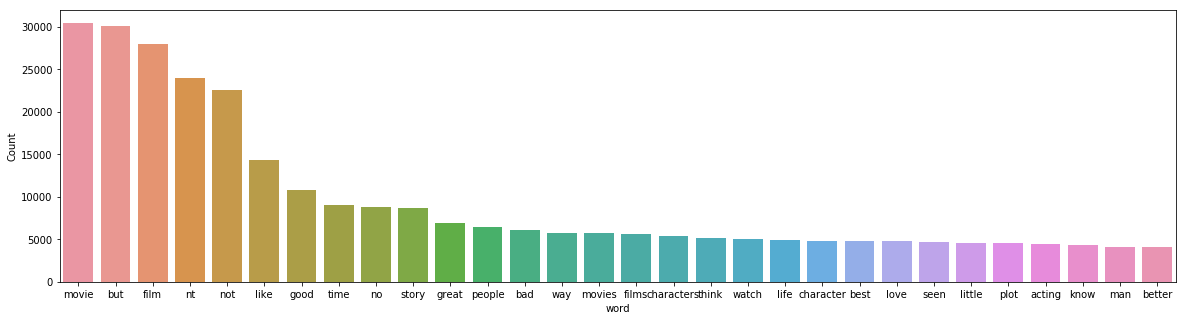

In [83]:
freq_words(df['review_cleaned'])

<br>

### Split Data

After cleaning and pre-processing of the reviews, we can now split our data into 3 sets — train, validation, and test — in the ratio of 70%, 15% and 15%, respectively. We will use the train set for traing our model, and validation and test sets to make predictions and evaluate our model.

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
# splitting data into train, test, and validation set
train, temp = train_test_split(df, stratify = df['class'], test_size=0.3, random_state=42)

test, val = train_test_split(temp, stratify = temp['class'], test_size=0.5, random_state=42)

In [90]:
train.shape, val.shape, test.shape

((12600, 4), (2700, 4), (2700, 4))

<br>

### Extracting Features from Cleaned Text

Now comes the interesting part. Since we will building a classification model, we can't directly feed text data to our model. We will have to extract numerical features from the cleaned text to build our model. We will create two sets of features — 
1. Bag-of-Words features
2. TF-IDF features

To learn more about feature extraction from text refer this [article](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/).

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [93]:
# build bag-of-words features for train data
bow = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))
bow_train = bow.fit_transform(train['review_cleaned'])

# build TF-IDF features for train data
tfidf = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                        sublinear_tf=True)
tfidf_train = tfidf.fit_transform(train['review_cleaned'])

In [94]:
# create features for validation and test set
bow_val = bow.transform(val['review_cleaned'])
tfidf_val = tfidf.transform(val['review_cleaned'])

bow_test = bow.transform(test['review_cleaned'])
tfidf_test = tfidf.transform(test['review_cleaned'])

In [95]:
print('BOW model:> Train features shape:', bow_train.shape, ' Validation features shape:', bow_val.shape, 
      ' Test features shape:', bow_test.shape)

print('TFIDF model:> Train features shape:', tfidf_train.shape, ' Validation features shape:', tfidf_val.shape,
      ' Test features shape:', tfidf_test.shape)

BOW model:> Train features shape: (12600, 42282)  Validation features shape: (2700, 42282)  Test features shape: (2700, 42282)
TFIDF model:> Train features shape: (12600, 42282)  Validation features shape: (2700, 42282)  Test features shape: (2700, 42282)


<br>

### Model Building

1) __Logistic Regression__ Model using bag-of-words features

In [96]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()

# train model on bag-of-words features
lr.fit(bow_train, train['class'])

In [98]:
#make predictions on validation set
bow_val_preds = lr.predict(bow_val)

#make predictions on test set
bow_test_preds = lr.predict(bow_test)

In [100]:
from sklearn.metrics import accuracy_score

In [103]:
# model evaluaton
print("Validation accuracy score: ", accuracy_score(val['class'], bow_val_preds))
print("Test accuracy score: ", accuracy_score(test['class'], bow_test_preds))

Validation accuracy score:  0.8766666666666667
Test accuracy score:  0.882962962962963


2) __Logistic Regression__ Model using TF-IDF features

In [ ]:
# train model on bag-of-words features
lr.fit(tfidf_train, train['class'])

In [105]:
#make predictions on validation set
tfidf_val_preds = lr.predict(tfidf_val)

#make predictions on test set
tfidf_test_preds = lr.predict(tfidf_test)

In [106]:
# model evaluaton
print("Validation accuracy score: ", accuracy_score(val['class'], tfidf_val_preds))
print("Test accuracy score: ", accuracy_score(test['class'], tfidf_test_preds))

Validation accuracy score:  0.8825925925925926
Test accuracy score:  0.8825925925925926


<br>

### What's Next?

So, this was our attempt to get you started with text classification. There are still a lot many things that you can try to improve your model performance and make it more robust. Some of them are listed below:

1. Use the entire IMDb movie dataset.
2. Use text normalization (stemming or lemmatization) to convert different forms of each word into one.
3. Use word embeddings such as word2vec, GLoVe, fasttext to create features.
4. Try different machine learning algorithms like SVM, random forest, XGBoost, LightGBM.
5. Apply deep learning models. 

Thanks for completing this project. Feel free to reach out to us. Happy Learning!

#### [Blog](https://www.analyticsvidhya.com/)
#### [Courses](https://trainings.analyticsvidhya.com/courses)
#### [Hackathons](https://datahack.analyticsvidhya.com/contest/all/)
#### [Disscussion Forums](https://discuss.analyticsvidhya.com)